<a href="https://colab.research.google.com/github/mgarbanzo/goes-r_datajam_2023/blob/main/DataJam_SUVI_Part_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

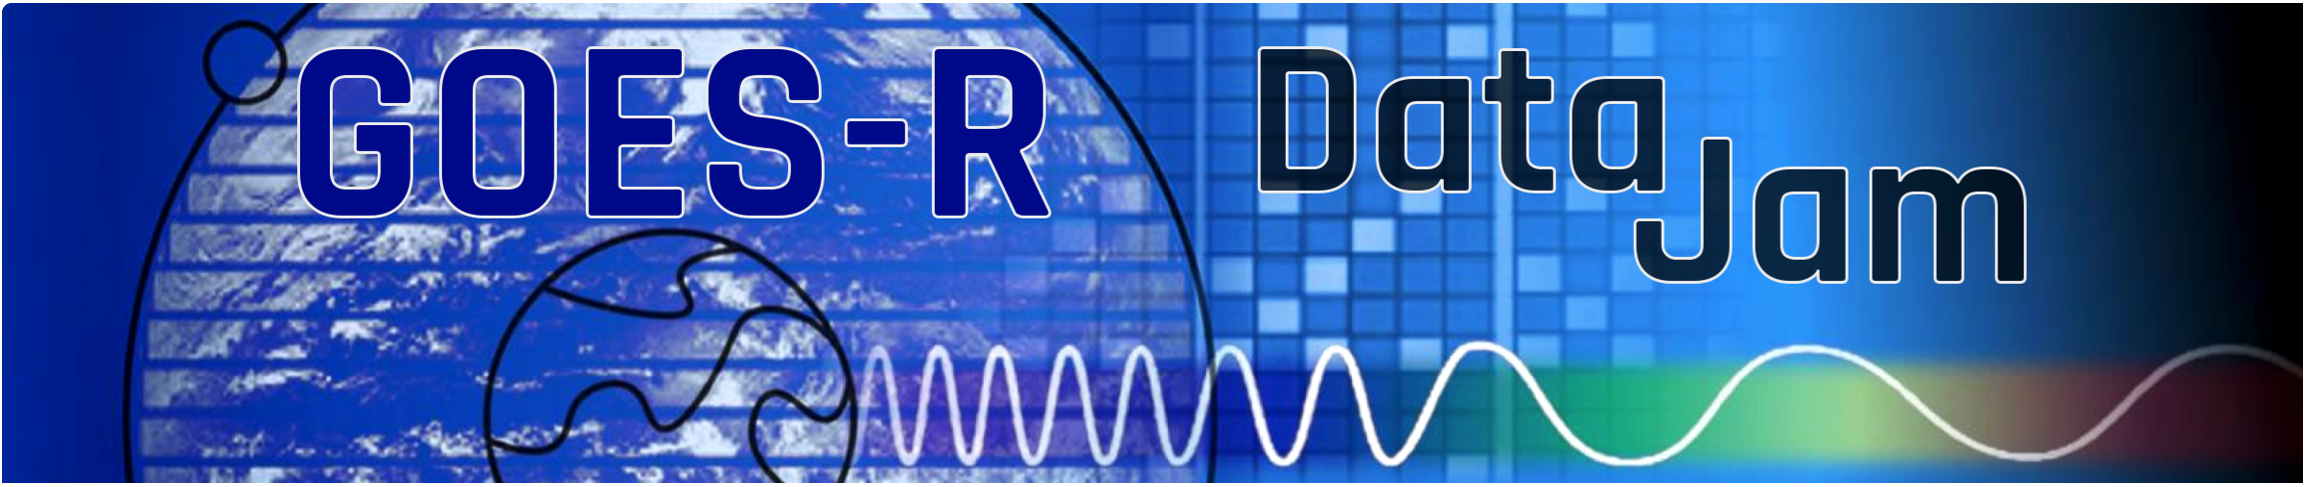

Diego Souza, Engineer, INPE (Brasil)

Dr. Marcial Garbanzo-Salas, Professor, UCR (Costa Rica)

# Looking at the animated Sun!

In this notebook we will get a LOT of information, clean it up a bit and then animate the remaining data.

To download a large amount of data we will use the Boto3 library, lets install it!

Also, to get a better finish and use the World Coordinate System (WCS) we will get the Astropy library.

In [1]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4


In [2]:
!pip install astropy

## Data Download

This code is more complicated that before.

We will get a LARGE amount of FITS files (not NetCDF):

In [3]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os

# Specify the AWS S3 bucket and the date and time for which you want to retrieve the data
bucket_name = 'noaa-goes16'
product_names = ['SUVI-L1b-Fe171']
year = 2023

# Create an S3 client
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Function to download files for a given day, year, and hour
def download_files_for_day_and_hour(year, day_of_year, hour):
    local_dir = './SUVI-DATA/'
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    for product_name in product_names:
        # Obtain the list of files in the S3 bucket for the specified date and hour
        prefix = f'{product_name}/{year}/{day_of_year:03d}/{hour:02d}/'
        objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

        # Download each file from the list
        for obj in objects.get('Contents', []):
            file_name = obj['Key'].split('/')[-1]
            s3_key = obj['Key']

            # Only download FITS files for the specified hour and within the first 10 minutes
            if file_name.endswith('.fits'):
                s3.download_file(bucket_name, s3_key, local_dir + file_name)
                print(f'Downloaded {file_name}')

for hour in range(00, 24):
    download_files_for_day_and_hour(year, 249, hour)

Downloaded OR_SUVI-L1b-Fe171_G16_s20232490000190_e20232490000200_c20232490000398.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490000291_e20232490000291_c20232490000503.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490004191_e20232490004201_c20232490004400.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490004291_e20232490004291_c20232490004507.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490008191_e20232490008201_c20232490008395.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490008291_e20232490008291_c20232490008504.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490012191_e20232490012201_c20232490012398.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490012291_e20232490012291_c20232490012507.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490016191_e20232490016201_c20232490016398.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490016291_e20232490016291_c20232490016504.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490020191_e20232490020201_c20232490020397.fits
Downloaded OR_SUVI-L1b-Fe171_G16_s20232490020291_e2023

There are two kinds of FITS files in there. We will only use one of those so we can safely remove the ones we will not use (we can only test for those files after the download).

In total there are around 700 files downloaded.

In [4]:
ls -lh /content/SUVI-DATA/ | wc -l

721


To clean the data we remove those with 0.1 standard deviation near the edge of the image.

In [5]:
import os
from astropy.io import fits
import numpy as np

# Path to data
path = '/content/SUVI-DATA/'

# List and sort files
files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.fits')])

for eachfile in files:
    with fits.open(eachfile) as hdul:
        data = hdul[0].data

    if np.std(data[:, 10]) > 0.1:
        os.remove(eachfile)

After removing those files there are 360 files left

In [6]:
ls -lh /content/SUVI-DATA/ | wc -l

361


## ANIMATION!

The following lines of code will create an animation of all those hours available during the 247th day of 2023!

After the animation is created we will save it to an mp4 file that can be downloaded and shared!

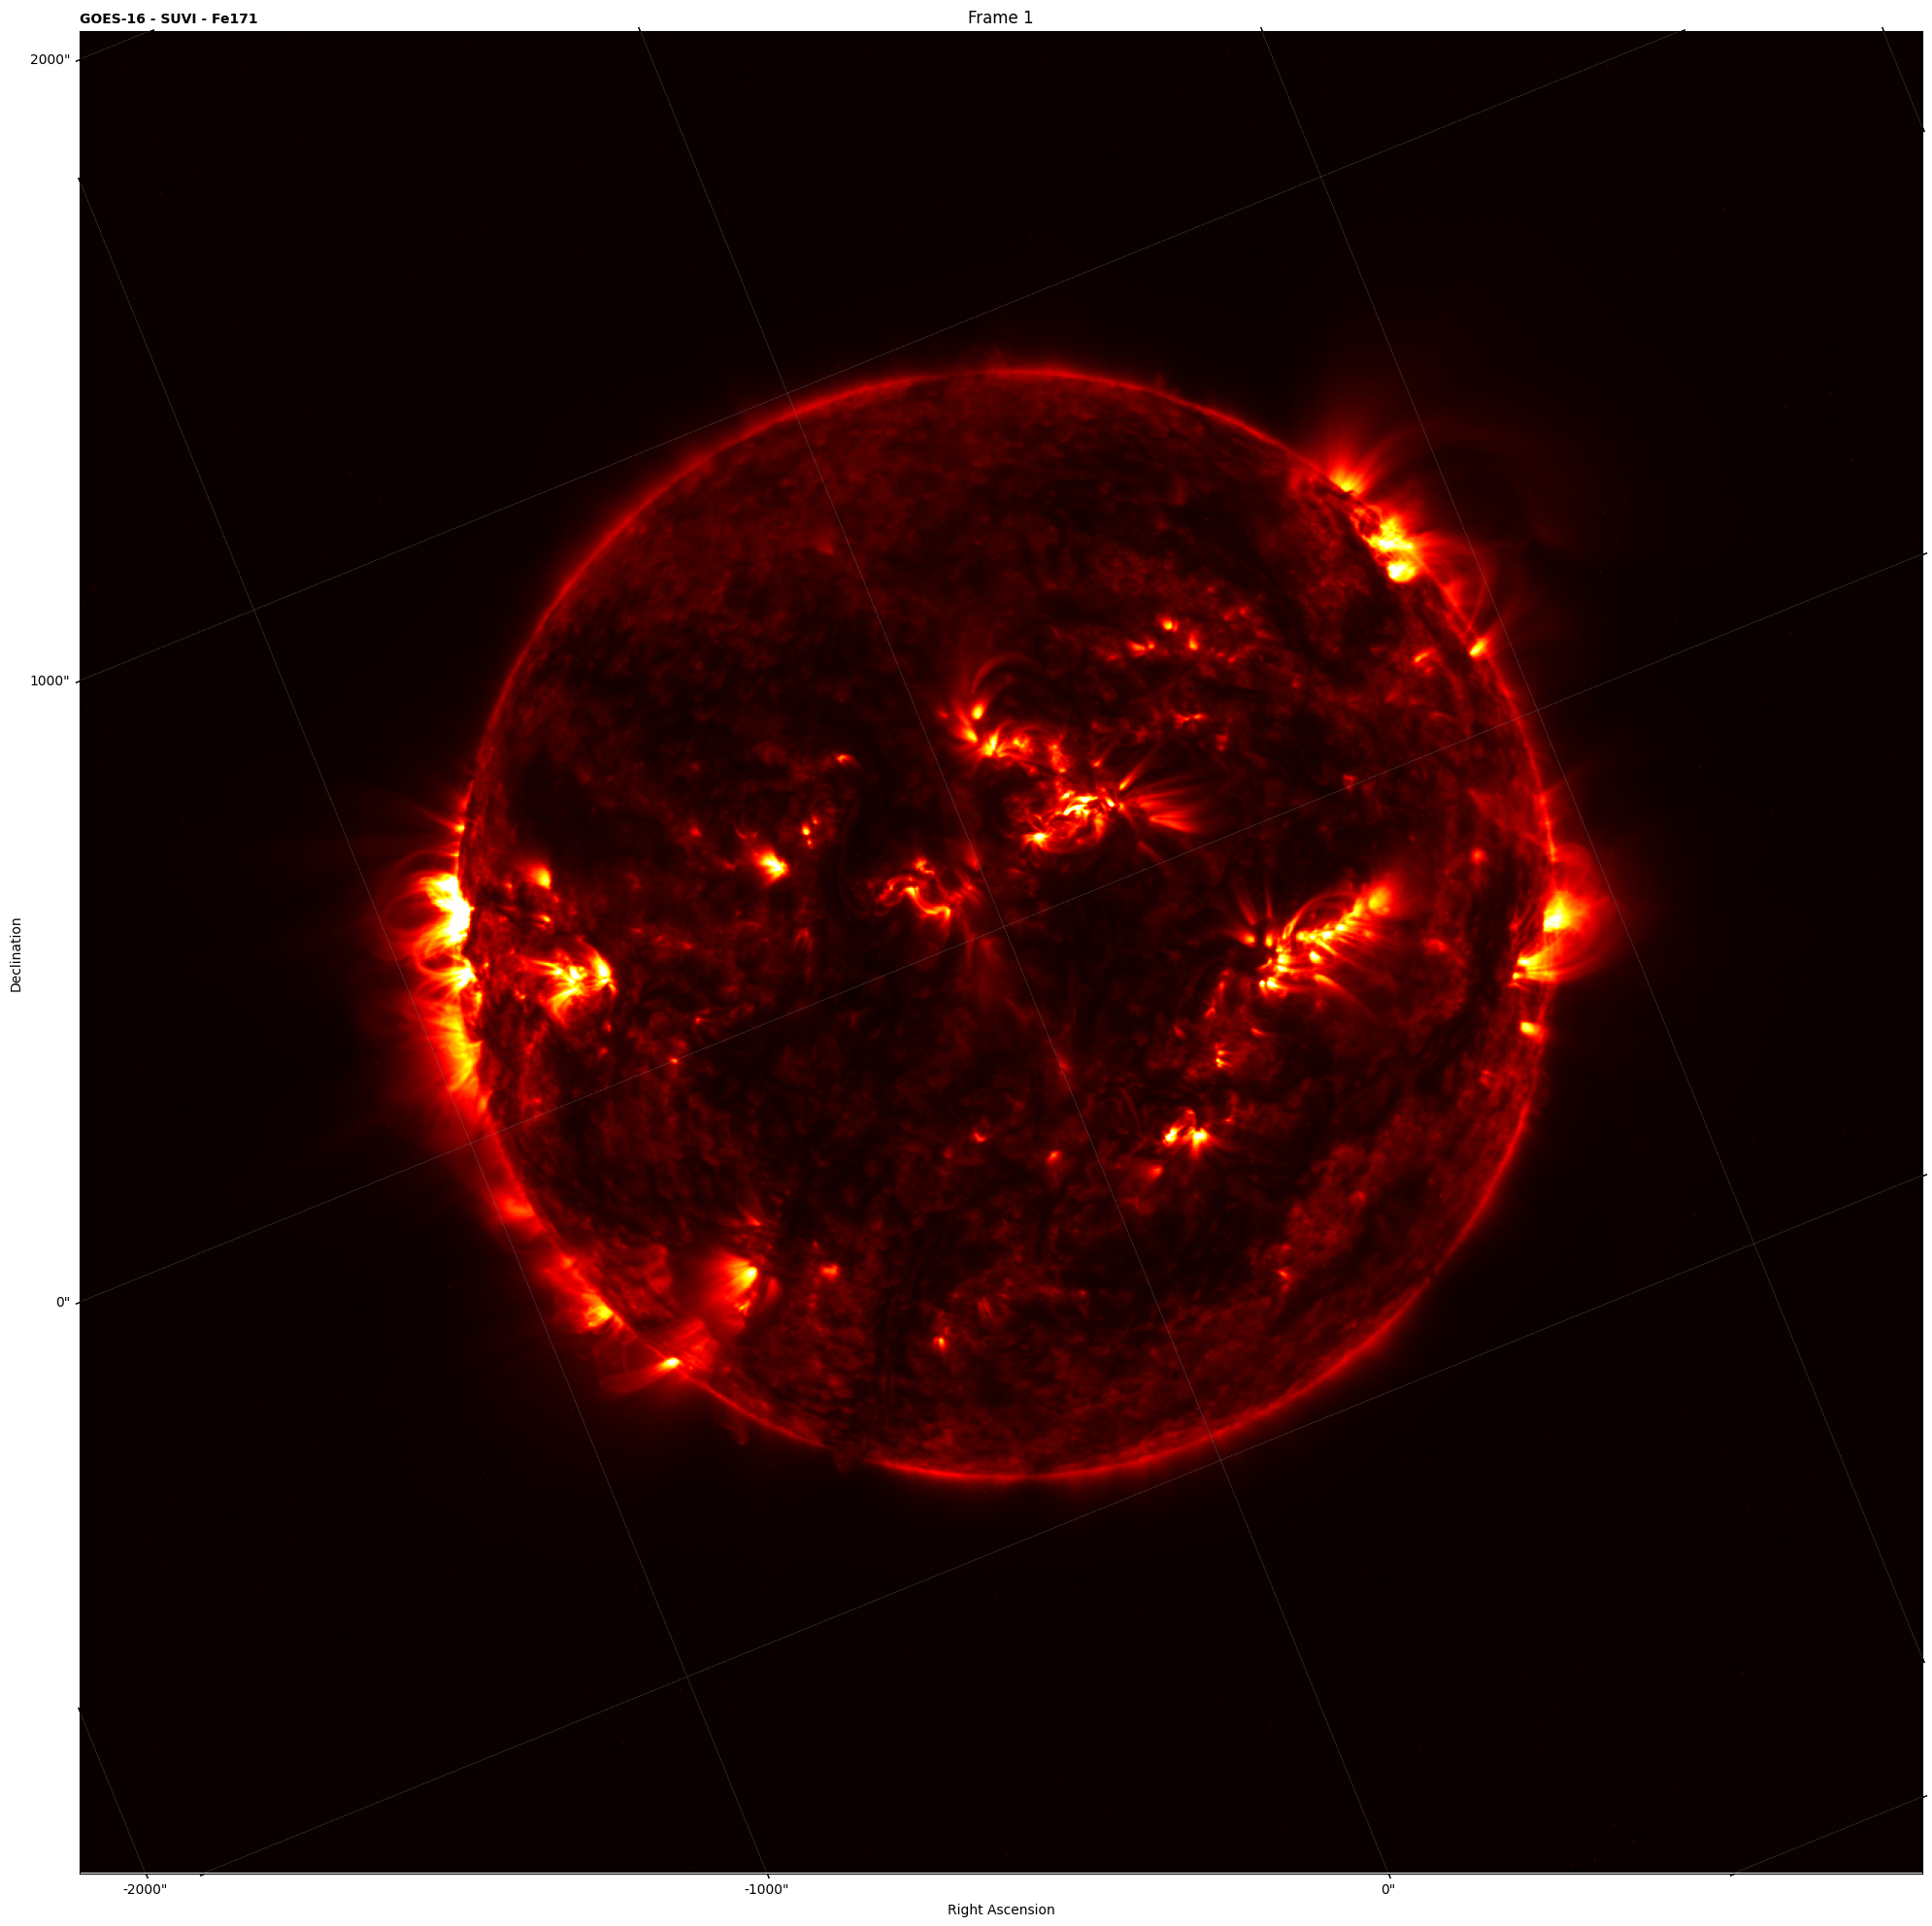

In [7]:
import os
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from astropy.io import fits
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning

# Suppress the AstropyWarning related to FITS file handling
warnings.simplefilter('ignore', category=AstropyWarning)

matplotlib.rcParams['animation.embed_limit'] = 2**128

# Path to data
path = '/content/SUVI-DATA/'

# List and sort files
files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.fits')])

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': WCS(fits.getheader(files[0]))})

# Open the first FITS file to initialize the animation
with fits.open(files[0]) as hdul:
    data = hdul[0].data
    norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=SqrtStretch())
    cax = ax.imshow(data, cmap='hot', vmin=0, vmax=8, animated=True, origin='lower')

def update(frame):
    with fits.open(files[frame]) as hdul:
        data = hdul[0].data
        wcs = WCS(hdul[0].header)
        date_obs = hdul[0].header.get('DATE-OBS', 'Unknown Date')
        file_name = os.path.basename(files[frame])
        image_descriptor = file_name.split('-L1b-')[1].split('_')[0]  # Extracting image descriptor

    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.grid(color='gray', ls='dotted', lw=0.5)
    ax.coords.grid(True, color='gray', ls='dotted', lw=0.5)
    plt.title('GOES-16 - SUVI - ' + str(image_descriptor), fontweight='bold', fontsize=10, loc='left')

    cax.set_array(data)
    ax.set_title(f"Frame {frame+1}")
    fig.tight_layout()
    return cax,

ani = animation.FuncAnimation(fig, update, frames=len(files), blit=True, repeat=True)

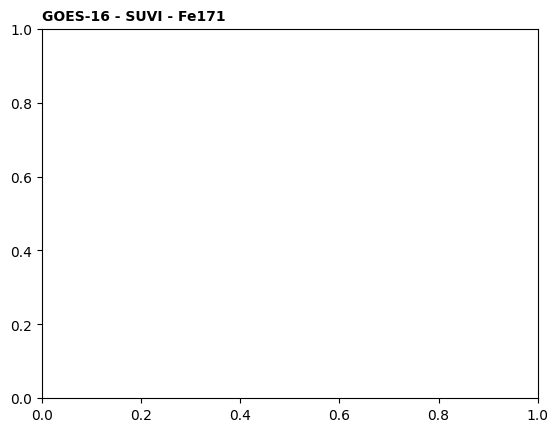

In [9]:
ani.save('animation_fits.mp4', writer='ffmpeg', fps=30)